# Termination Criteria 

In this notebook we analyze the behaviour of the solutions with respect to the number of generations. Obviously, as the number of generation increases we expect that the solutions get better (or at least they do not get worse).

The goal is to define a criterium to stop the algorithm if it does not improve significantly the quality of the solutions.

Let's define a a toy problem on which we are going to test the criteria.

In [18]:
from _solver import GeneticBrickSolver
import matplotlib.pyplot as plt
import numpy as np
random_seed = 123
np.random.seed(random_seed)

In [19]:
population_size = 25
max_generations = 1000

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size//10
tournament_size = population_size//10

columns_per_individual = 10
bricks_per_column = 15
number_of_bricks = columns_per_individual*bricks_per_column

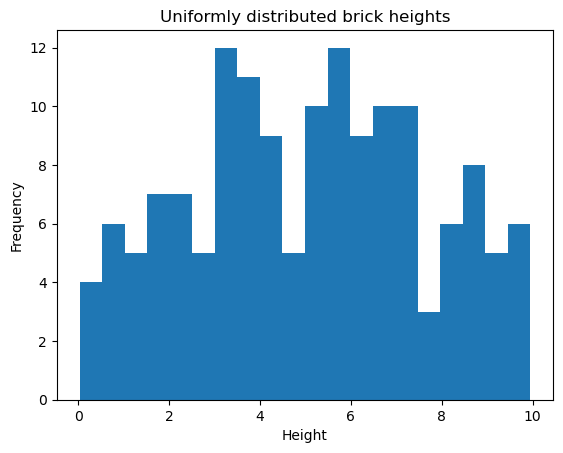

In [20]:
unif_brick_heights = np.random.uniform(0, 10, number_of_bricks)

plt.hist(unif_brick_heights, bins=20)
plt.title('Uniformly distributed brick heights')
plt.ylabel('Frequency')
plt.xlabel('Height')
plt.show()

Let's solve the problem using as termination criterium only `max_generations`

In [21]:
GBS = GeneticBrickSolver(population_size,
                         mutation_rate,
                         crossover_rate,
                         max_generations,
                         tournament_size,
                         k_elitism,
                         random_seed)    

GBS.solve(unif_brick_heights,
          columns_per_individual,
          bricks_per_column)

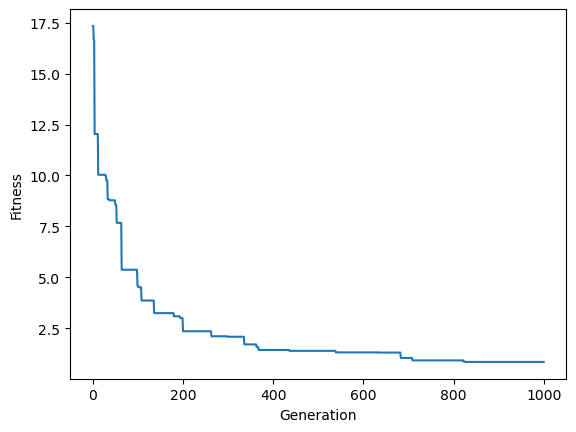

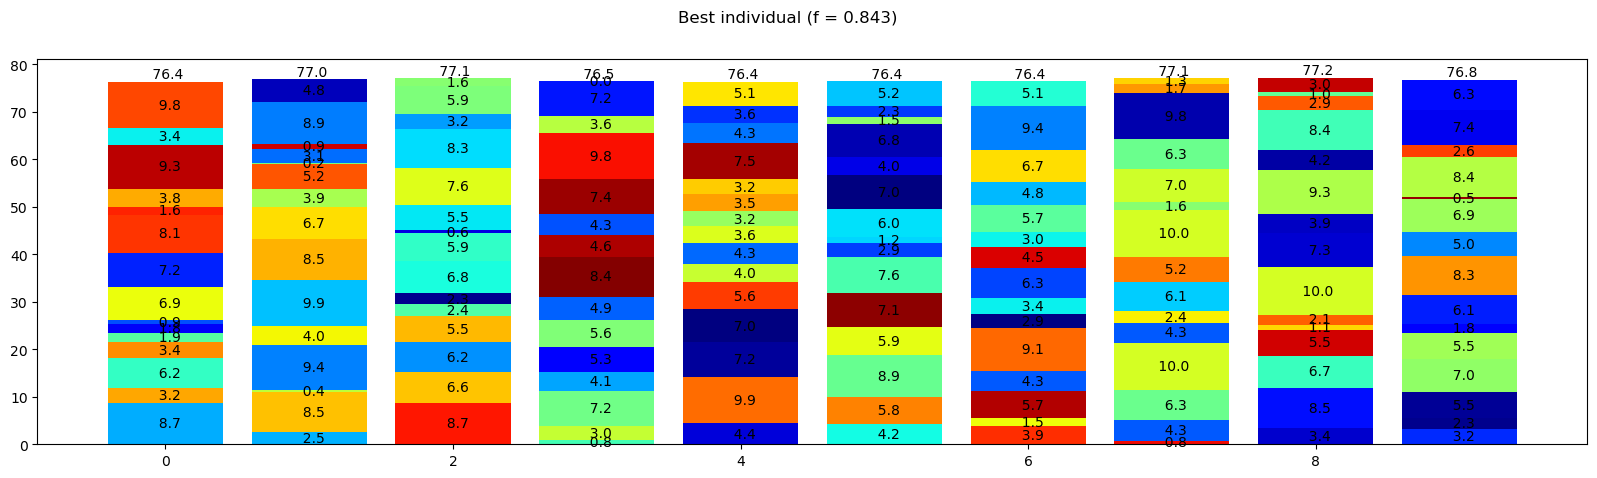

In [22]:
GBS.plot_fitness()
GBS.plot_best_individual()

## First Method: Improvement

Let's generate a random set of brick heights (uniformly distributed between 0 and 10)


The fitness values drop really fast in the first 200 generations.
Afterwards, the fitness function reaches a plateau and the improvements are really small.

Pratically, we want to reach a fair tradeoff between the quality of the solution
and the time it takes to reach it.

At $i$-th generation, the last improvement (minimizing $f$) reached by the algorithm can be defined as follows

$$
\Delta_{i} =  
\begin{cases}
\Delta_{i-1} & \text{if }  f(i-1)-f(i) = 0 \\
f(i-1)-f(i) & \text{if }  f(i-1)-f(i) > 0 \\
\end{cases}
$$

where $f(j)$ is the best value of the fitness function found until j-th generation.

If the last improvement reached by the algorithm is large, a good strategy is to
keep searching. Otherwise, if the improvement is very small, it is better to
stop the algorithm. So we define the probability of stopping the algorithm at $i$-th generation  as

$$
    P_{\text{STOP}}(i) = e^{-\Delta_i / T}
$$

where $T \in (0, \infty)$ is a coefficient that determines how much we are
interested in saving time instead of improving the quality of the solution instead.

Let's solve the problem using this termination criterium.



In [25]:
GBS = GeneticBrickSolver(population_size,
                         mutation_rate,
                         crossover_rate,
                         max_generations,
                         tournament_size,
                         k_elitism,
                         random_seed) 

GBS.solve_stopping_criterium(unif_brick_heights,
                             columns_per_individual,
                             bricks_per_column,
                             'improvement',
                             T = 0.001)

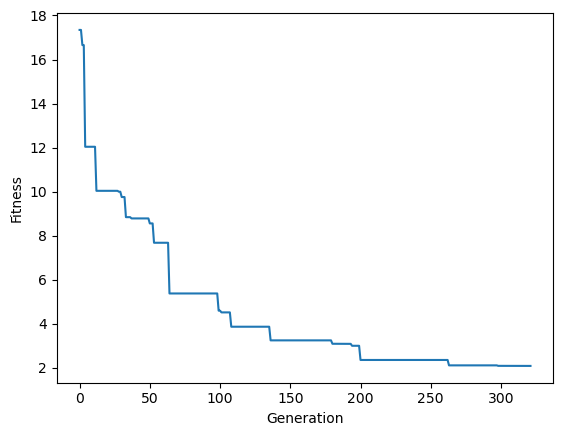

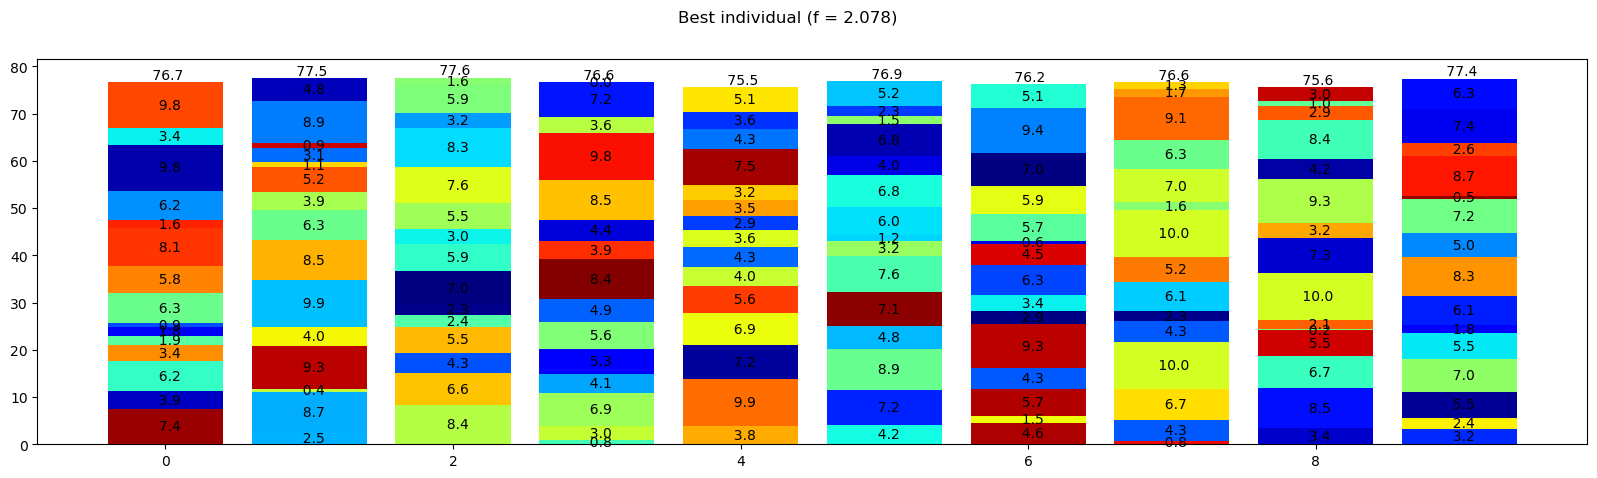

In [7]:
GBS.plot_fitness()
GBS.plot_best_individual()

This approach seems to be very dependant from the choice of the coefficient $T$. Since it ranges in $(0, \infty)$, it is very difficult to assign to this coefficient a practical meaning.

We have to try multiple values of $T$ in order to find the best one but it does not make sense in a real scenario.

## Second Method: Stagnation

In the previous method, we took into consideration only the best fitness that the algorithm reaches at every generation.

To understand if the algorithm has converged to a good solution, we could check the variability of the fitness of each individual of the population. When the variability is small, it seems resonable to stop the algorithm.

We can reuse the previous framework with some adjustments.

We set
$$
    P_{\text{STOP}}(i) = e^{-\Delta_i / T}
$$

but $\Delta_i$ is defined as the standard deviation of the fitness between the individuals that belong to the $i$-th generation
$$
    \Delta_i = \frac{1}{N} \sqrt{\sum_{k = 1}^N \left(f(k) - \bar{f} \, \right)^2} 
$$

where N is the population size, $f(k)$ is the fitness of the $k$-th individual and $\bar{f}$ is the mean fitness of the population.

The parameter $T$ is the importance assigned to the saving time.


In [12]:
GBS = GeneticBrickSolver(population_size,
                         mutation_rate,
                         crossover_rate,
                         max_generations,
                         tournament_size,
                         k_elitism,
                         random_seed) 

GBS.solve_stopping_criterium(unif_brick_heights,
                             columns_per_individual,
                             bricks_per_column,
                             'stagnation',
                             T = 0.001)

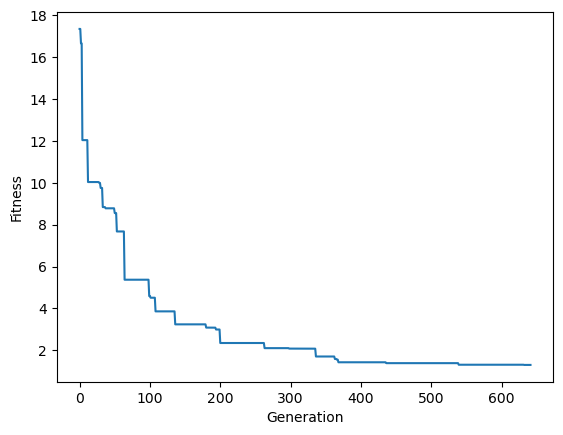

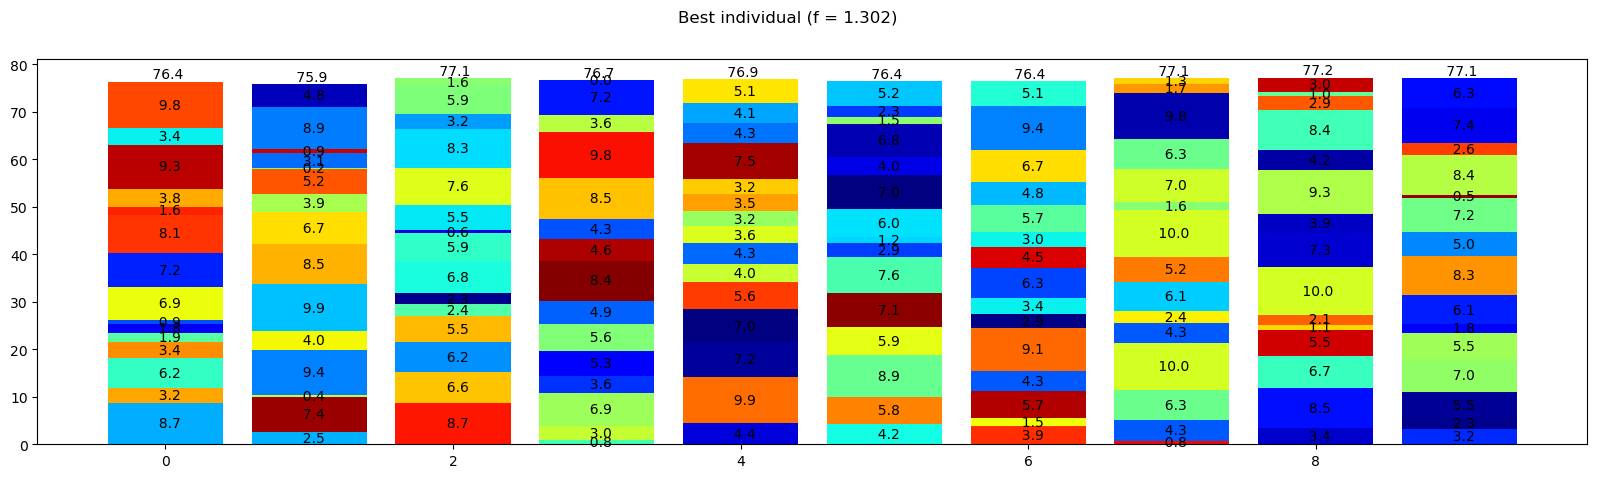

In [9]:
GBS.plot_fitness()
GBS.plot_best_individual()

The stagnation method offers a more intuitive interpretation than the improvement method. For example, we want to reach a very small standard deviation in the fitnesses of the population with a high probability $P_{\text{stop}} = 0.5$. Let's fix $\sigma = 0.01$ so we have to set $T = 0.014$.